# Necessary Imports

In [273]:
from bs4 import BeautifulSoup as bs
import pandas as pd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
import numpy as np
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.by import By
import pickle
import time
import sys

# Webscraping
These code blocks create an instance of the webscraper object, and scrapes levelsfyi for its data using a selenium driver

In [253]:
class WebScraper():
    def __init__(self):
        serv = Service('/usr/bin/chromedriver')
        self.auth = False
        self.driver = webdriver.Chrome(service=serv)
        self.salaries_list = []
        self.levels_list = []
        self.offer_date_list = []
        self.years_at_company_list = []
        self.years_of_experience_list = []
        self.soup = None

    # initializes the client to levels.fyi
    def initialize_client(self):
        url = 'https://www.levels.fyi/companies/google/salaries/software-engineer?offset=0'
        self.driver.get(url)
        return

    #function that removes the blur from the salary list
    def remove_blur(self):
        # click buttons to remove the blur from salary data
        self.driver.execute_script("document.querySelector('.css-kg5r73').scrollIntoView();")
        self.driver.execute_script("document.querySelector('.css-1q3lwpg').click();")
        self.driver.execute_script("document.querySelector('.css-boyo6o').click();")
        self.auth = True
        return

    #function to filter salaries to United States only
    def filter_country(self):
        # opening dropdown
        self.driver.execute_script("document.querySelector('.css-ch9u3p').click();")

        # scroll United States into view
        self.driver.execute_script("""
            let buttons = document.querySelectorAll('.css-wbg7z3 li');
            let us = buttons[buttons.length-1].querySelector('label span input');
            us.scrollIntoView();
        """)
        action = ActionChains(self.driver)
        us = self.driver.find_elements(By.CSS_SELECTOR,'.css-wbg7z3 li')[-1]
        action.click(us)
        action.perform()

    #function that increases the dropdown limit to 50
    def increase_limit(self):
        # increase rows per page to 50
        self.driver.execute_script("document.querySelector('.css-1wxoufr').click();")
        action = ActionChains(self.driver)
        action.key_down(Keys.ENTER)
        action.key_up(Keys.ENTER)
        action.key_down(Keys.DOWN)
        action.key_up(Keys.DOWN)
        action.key_down(Keys.DOWN)
        action.key_up(Keys.DOWN)
        action.key_down(Keys.ENTER)
        action.key_up(Keys.ENTER)
        action.perform()
        time.sleep(5)
        return

    #expands all salary entries
    def expand_entries(self):
        # click all the salary dropdown buttons
        self.driver.execute_script("""
            let dropDowns = document.querySelectorAll(".css-5mf6ol");
            for (const dropDown of dropDowns){
                dropDown.click();
            };
        """)
        time.sleep(2)
        return

    #function that gets the next page of salaries
    def get_next_page(self):
        #get the page buttons and click the > one
        self.driver.execute_script("""
            let buttons = document.querySelectorAll('.css-pvt3pn');
            buttons[buttons.length-1].click();
        """)
        return

    #updates soup object of the page
    def get_soup(self):
        html = self.driver.page_source
        self.soup = bs(html,'html.parser')
        return

    #function to create soup object of page, and collect data
    def collectData(self):
        #all salary elements
        self.salaries_list += [s.text.strip() for s in self.soup.select('.css-10sgg15')]

        #get 'level' elements
        self.levels_list += [s.text.strip() for s in self.soup.select('.expanded-salary-view_flexRow__yvqab .expanded-salary-view_levelContainer__N_p7A p')]

        # get date hired elements
        self.offer_date_list += [window.select('.expanded-salary-view_detailField__giEDA')[2].select('p')[0].text for window in self.soup.select('.css-1mpid8k')]

        # get years at company elements
        self.years_at_company_list += [s.text.strip() for s in self.soup.select('.expanded-salary-view_yearsAtCompanyTextContainer__2BwXQ div p')]

        # get years of experience elements
        self.years_of_experience_list += [s.text.strip() for s in self.soup.select('.expanded-salary-view_yearsOfExperienceTextContainer__VuXhv div p div')]

        return

    # clear data
    def clear_data(self):
        self.salaries_list = []
        self.levels_list = []
        self.offer_date_list = []
        self.years_at_company_list = []
        self.years_of_experience_list = []

    # function that performs a full scrape of the levels fyi google salaries
    def scrape(self):
        self.clear_data()
        self.initialize_client()
        if not self.auth:
            self.remove_blur()
        self.increase_limit()
        self.filter_country()
        self.expand_entries()
        self.get_soup()
        self.collectData()
        for i in range(19):
            self.get_next_page()
            time.sleep(1)
            self.expand_entries()
            self.get_soup()
            self.collectData()

    # collects the soup of just one page for testing purposes
    def one_soup(self):
        self.initialize_client()
        if not self.auth:
            self.remove_blur()
        self.filter_country()
        self.increase_limit()
        self.expand_entries()
        self.get_soup()

    def print_data(self):
        print(f'Salaries: Count = {len(self.salaries_list)}, Values = {self.salaries_list}')
        print(f'Levels: Count = {len(self.levels_list)}, Values = {self.levels_list}')
        print(f'Dates: Count = {len(self.offer_date_list)}, Values = {self.offer_date_list}')
        print(f'Years At Company: Count = {len(self.years_at_company_list)}, Values = {self.years_at_company_list}')
        print(f'Years of Experience: Count = {len(self.years_of_experience_list)}, Values = {self.years_of_experience_list}')


In [254]:
scraper = WebScraper()

In [255]:
scraper.scrape()

# Data Organizing and Cleaning with Pandas

In [264]:
d = {'Salary':scraper.salaries_list,'Level':scraper.levels_list,'Days Into Year':scraper.offer_date_list,'Years at Company':scraper.years_at_company_list,'Years of Experience':scraper.years_of_experience_list}
df = pd.DataFrame(d)
df

,Salary,Level,Days Into Year,Years at Company,Years of Experience
0,"$239,900",L4,Offer from 11/21/2022,0 yrs,2 yrs
1,"$195,000",L3,Employee as of 11/20/2022,1 yrs,4 yrs
2,"$220,000",L3,Employee as of 11/20/2022,3 yrs,3 yrs
3,"$202,000",L3,Employee as of 11/20/2022,2 yrs,4 yrs
4,"$350,000",L5,Employee as of 11/20/2022,4 yrs,8 yrs
...,...,...,...,...,...
843,"$325,000",L4,Offer from 07/28/2022,0 yrs,6 yrs
844,"$400,000",L5,Employee as of 07/28/2022,1 yrs,8 yrs
845,"$240,000",L3,Employee as of 07/28/2022,2 yrs,4 yrs
846,"$242,900",L4,Offer from 07/28/2022,0 yrs,7 yrs


In [265]:
# removing all invalid job levels then converting them to integers
valid_levels = {'L3':1,'L4':2,'L5':3,'L6':4,'L7':5,'L8':6}
df = df[df.Level.isin(valid_levels)]
def convertLevel(level):
    return valid_levels[level]
df["Level"] = df["Level"].apply(convertLevel)
df.Level.value_counts()

2    293
1    284
3    180
4     54
5     10
6      4
Name: Level, dtype: int64

In [266]:
# converting the salaries to integers
def convertSalary(salary):
    return int(''.join(salary[1:].split(',')))
df["Salary"] = df["Salary"].apply(convertSalary)
df.head()

,Salary,Level,Days Into Year,Years at Company,Years of Experience
0,239900,2,Offer from 11/21/2022,0 yrs,2 yrs
1,195000,1,Employee as of 11/20/2022,1 yrs,4 yrs
2,220000,1,Employee as of 11/20/2022,3 yrs,3 yrs
3,202000,1,Employee as of 11/20/2022,2 yrs,4 yrs
4,350000,3,Employee as of 11/20/2022,4 yrs,8 yrs


In [267]:
# converting the offer date to just days since January 1st. This variable could be a factor of economic trends
months = [31,28,31,30,31,30,31,31,30,31,30,31]
monthsSum = [sum(months[:i]) for i in range(len(months))]
def convertDate(date):
    date = date.split(' ')[-1].split('/')
    return monthsSum[int(date[0])-1] + int(date[1])
df["Days Into Year"] = df["Days Into Year"].apply(convertDate)

In [268]:
# convert year columns to just integer
def convertYear(year):
    return int(year.split(' ')[0])
df["Years at Company"] = df["Years at Company"].apply(convertYear)
df["Years of Experience"] = df["Years of Experience"].apply(convertYear)

In [269]:
df

,Salary,Level,Days Into Year,Years at Company,Years of Experience
0,239900,2,325,0,2
1,195000,1,324,1,4
2,220000,1,324,3,3
3,202000,1,324,2,4
4,350000,3,324,4,8
...,...,...,...,...,...
843,325000,2,209,0,6
844,400000,3,209,1,8
845,240000,1,209,2,4
846,242900,2,209,0,7


# Charting some graphs for salary

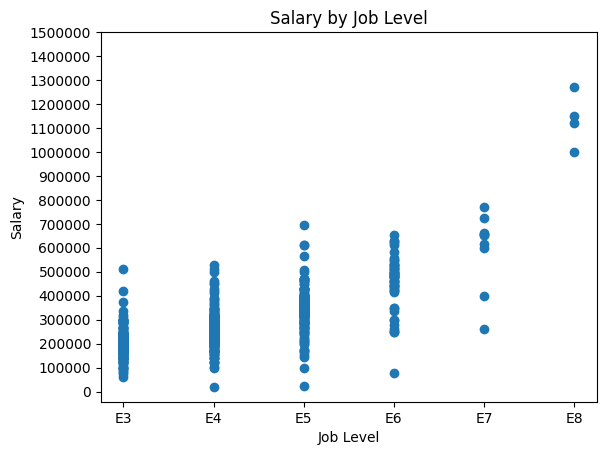

In [285]:
plt.scatter(df["Level"],df["Salary"])
plt.title("Salary by Job Level")
plt.xlabel("Job Level")
plt.ylabel("Salary")
plt.ticklabel_format(axis='both', style='plain')
plt.yticks([i for i in range(0,1600000,100000)])
plt.xticks([1,2,3,4,5,6],['E3','E4','E5','E6','E7','E8'])
plt.show()

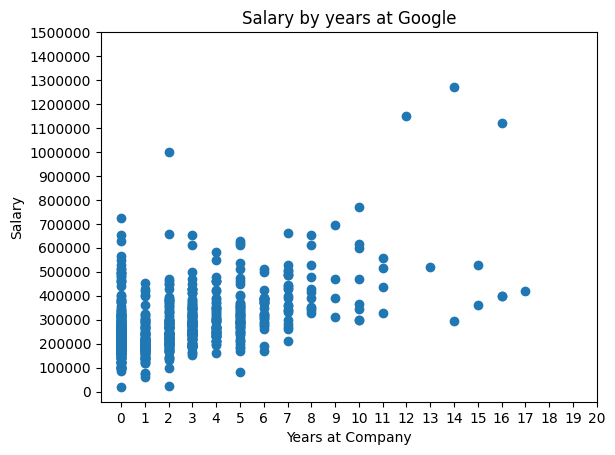

In [287]:
plt.scatter(df["Years at Company"],df["Salary"])
plt.title("Salary by years at Google")
plt.xlabel("Years at Company")
plt.ylabel("Salary")
plt.ticklabel_format(axis='both', style='plain')
plt.yticks([i for i in range(0,1600000,100000)])
plt.xticks([i for i in range(21)])
plt.show()

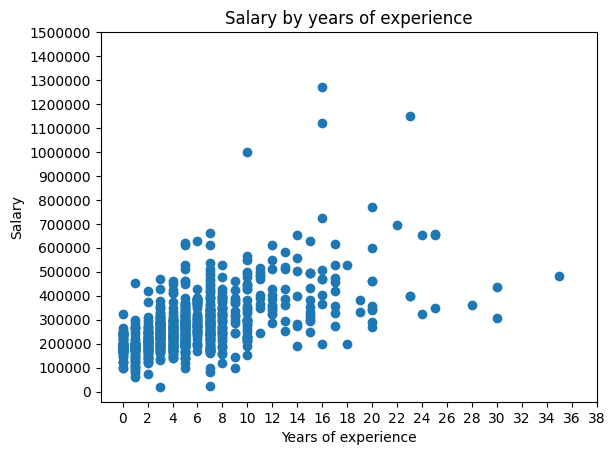

In [291]:
plt.scatter(df["Years of Experience"],df["Salary"])
plt.title("Salary by years of experience")
plt.xlabel("Years of experience")
plt.ylabel("Salary")
plt.ticklabel_format(axis='both', style='plain')
plt.yticks([i for i in range(0,1600000,100000)])
plt.xticks([i for i in range(0,40,2)])
plt.show()